<h1 style="color:#3a7aad">War on Arrhythmia 2.0</h1>

Application of Machine Learning Techniques on the Early Detection of a Heart Arrhythmia

By Ahmad Chaiban

In [4]:
import wfdb
from glob import glob

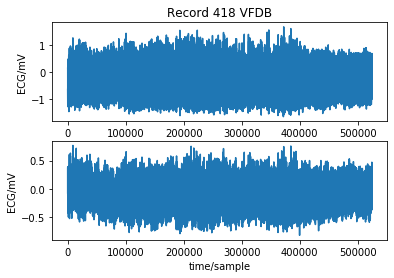

{'record_name': '418', 'n_sig': 2, 'fs': 250, 'counter_freq': None, 'base_counter': None, 'sig_len': 525000, 'base_time': None, 'base_date': None, 'comments': [], 'sig_name': ['ECG', 'ECG'], 'p_signal': array([[-0.64 , -0.07 ],
       [-0.91 , -0.065],
       [-0.935, -0.06 ],
       ...,
       [-0.495, -0.245],
       [-0.58 , -0.295],
       [-0.68 , -0.325]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['418.dat', '418.dat'], 'fmt': ['212', '212'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [200.0, 200.0], 'baseline': [0, 0], 'units': ['mV', 'mV'], 'adc_res': [12, 12], 'adc_zero': [0, 0], 'init_value': [-128, -14], 'checksum': [1830, -5967], 'block_size': [0, 0]}


In [20]:
record = wfdb.rdrecord('./Data_thesis/VFDB/418')
wfdb.plot_wfdb(record=record, title='Record 418 VFDB')
print(record.__dict__)

In [17]:
sample_record = record.p_signal
sample_record[:10]

array([[-0.64 , -0.07 ],
       [-0.91 , -0.065],
       [-0.935, -0.06 ],
       [-0.93 , -0.035],
       [-0.935, -0.04 ],
       [-0.955, -0.055],
       [-0.95 , -0.06 ],
       [-0.95 , -0.055],
       [-0.94 , -0.03 ],
       [-0.925,  0.   ]])

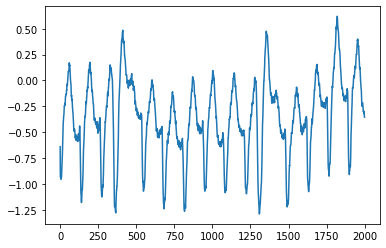

In [28]:
import matplotlib.pyplot as plt 

plt.plot(sample_record[:, 0][:2000])